In [1]:
import torch

In [2]:
# hyperparameters
batch_size = 16
block_size = 40 # A ajuster en fonction de la longueur max de l'input
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64
n_head = 8
dropout = 0.2

## Data preparation

Cette section comporte des travaux pour obtenir des un dataset composé de séquence de token.

On choisit pour ce premier essai de tokeniser à chaque lettre.

In [8]:
import pandas as pd

In [9]:
data = pd.read_csv("data.csv")
data.head()

,surname,firstname,occupation,link,age,sex
0,chardon,marie,idem,fille,30.0,femme
1,lhopital,louis-jean,sp,chef,67.0,homme
2,papin,marie,idem,idem,15.0,femme
3,lavocat,marie,NaN,femme,NaN,femme
4,benne,marguerite,NaN,NaN,78.0,femme


In [10]:
data = data.fillna('')
data["age"] = data["age"].astype(str)
data.head()

,surname,firstname,occupation,link,age,sex
0,chardon,marie,idem,fille,30.0,femme
1,lhopital,louis-jean,sp,chef,67.0,homme
2,papin,marie,idem,idem,15.0,femme
3,lavocat,marie,,femme,,femme
4,benne,marguerite,,,78.0,femme


In [11]:
# data["record"] = data["surname"] + ',' + data["firstname"] + ',' + data["occupation"] + ',' + data["link"] + ',' + data["age"]
data["record"] = data["firstname"] + ',' + data["occupation"] + ',' + data["link"] + ',' + data["age"]
data["sex_binary"] = data["sex"].apply(lambda x: 1 if x == "femme" else 0)
data.head()

,surname,firstname,occupation,link,age,sex,record,sex_binary
0,chardon,marie,idem,fille,30.0,femme,"marie,idem,fille,30.0",1
1,lhopital,louis-jean,sp,chef,67.0,homme,"louis-jean,sp,chef,67.0",0
2,papin,marie,idem,idem,15.0,femme,"marie,idem,idem,15.0",1
3,lavocat,marie,,femme,,femme,"marie,,femme,",1
4,benne,marguerite,,,78.0,femme,"marguerite,,,78.0",1


In [8]:
data["record"].apply(lambda s: len(s)).max()

37

In [8]:
with open("data.csv", 'r', encoding='utf-8') as f:
    text = f.read()

In [9]:
chars = [" "] + sorted(list(set(text)))
vocab_size = len(chars)

In [10]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


In [11]:
data["encoded"] = data["record"].apply(encode)
data.head()

,surname,firstname,occupation,link,age,sex,record,sex_binary,encoded
0,chardon,marie,idem,fille,30.0,femme,"chardon,marie,idem,fille,30.0",1,"[17, 22, 15, 32, 18, 29, 28, 2, 27, 15, 32, 23..."
1,lhopital,louis-jean,sp,chef,67.0,homme,"lhopital,louis-jean,sp,chef,67.0",0,"[26, 22, 29, 30, 23, 34, 15, 26, 2, 26, 29, 35..."
2,papin,marie,idem,idem,15.0,femme,"papin,marie,idem,idem,15.0",1,"[30, 15, 30, 23, 28, 2, 27, 15, 32, 23, 19, 2,..."
3,lavocat,marie,,femme,,femme,"lavocat,marie,,femme,",1,"[26, 15, 36, 29, 17, 15, 34, 2, 27, 15, 32, 23..."
4,benne,marguerite,,,78.0,femme,"benne,marguerite,,,78.0",1,"[16, 19, 28, 28, 19, 2, 27, 15, 32, 21, 35, 19..."


In [12]:
data["padded_encoded"] = data["encoded"].apply(lambda seq: seq + [0] * (block_size - len(seq)))

In [13]:
n_train = int(0.9 * len(data))
x_train = torch.tensor(data["padded_encoded"][:n_train].to_list(),dtype=torch.long)
y_train = torch.tensor(data["sex_binary"][:n_train].to_list())
x_val = torch.tensor(data["padded_encoded"][n_train:].to_list(), dtype=torch.long)
y_val = torch.tensor(data["sex_binary"][n_train:].to_list())

In [14]:
x_train.shape

torch.Size([216, 44])

In [15]:
y_val

tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1])

In [16]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    x_data, y_data = (x_train, y_train) if split == 'train' else (x_val, y_val)
    ix = torch.randint(len(x_data), (batch_size,))
    x = x_data[ix]
    y = y_data[ix]
    x, y = x.to(device), y.to(device)
    return x, y

In [17]:
x, y = get_batch("train")
x.shape, y.shape

(torch.Size([16, 44]), torch.Size([16]))

## Wrapping everything in custom Dataset and Dataloader objetcs

On reprend les travaux de la section précédente, sauf que cette fois-ci on englobe le tout dans des objets Dataset et Dataloader de PyTorch.

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd

In [4]:
with open("data.csv", 'r', encoding='utf-8') as f:
    text = f.read()

chars = [" "] + sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


class CensusDataset(Dataset):
    def __init__(self, file_path, train: bool, device):
        data = pd.read_csv("data.csv")
        data = data.fillna('')
        data["age"] = data["age"].astype(str)
        # data["record"] = data["surname"] + ',' + data["firstname"] + ',' + data["occupation"] + ',' + data["link"] + ',' + data["age"]
        data["record"] = data["firstname"] + ',' + data["occupation"] + ',' + data["link"] + ',' + data["age"]
        data["sex_binary"] = data["sex"].apply(lambda x: 1 if x == "femme" else 0)
        data["encoded"] = data["record"].apply(encode)
        data["padded_encoded"] = data["encoded"].apply(lambda seq: seq + [0] * (block_size - len(seq)))

        n_train = int(0.9 * len(data))
        if train:
            self.sequences = torch.tensor(data["padded_encoded"][:n_train].to_list(), dtype=torch.long).to(device)
            self.sexes = torch.tensor(data["sex_binary"][:n_train].to_list(),dtype=torch.long).to(device)
        else:
            self.sequences = torch.tensor(data["padded_encoded"][n_train:].to_list(), dtype=torch.long).to(device)
            self.sexes = torch.tensor(data["sex_binary"][n_train:].to_list(),dtype=torch.long).to(device)
    
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.sexes[idx]


In [6]:
vocab_size

47

In [7]:
training_data = CensusDataset("data.csv", True, device)
test_data = CensusDataset("data.csv", False, device)

In [8]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

## Basic solution

On essaye juste une solution simple qui consiste pour un prénom donné à tirer le sexe :  

- soit de façon binaire en tirant 0 si la fréquence que le prénom soit donné à un homme est <= 0.5, 1 sinon ;
- soit selon une Bernoulli de paramètre la fréquence que le prénom soit donné à un homme.

In [9]:
import pandas as pd

In [10]:
firstname_with_sex = pd.read_csv("firstname_with_sex.csv", sep=';')
firstname_with_sex.head()

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


In [11]:
firstname_with_sex["frequency"] = firstname_with_sex["female"] / (firstname_with_sex["female"] + firstname_with_sex["male"])
firstname_with_sex.head()

,firstname,male,female,frequency
0,marie,10145,2390322,0.995774
1,jean,1869615,6476,0.003452
2,pierre,1475841,5047,0.003408
3,jeanne,1765,1097397,0.998394
4,françois,1089009,5951,0.005435


In [12]:
female_frequency = {}

for _, row in firstname_with_sex.iterrows():
    female_frequency[row["firstname"]] = row["frequency"]

female_frequency["camille"]

0.3184849409405919

In [14]:
import torch.nn as nn

class SimpleDeterministicModel(nn.Module):
    def __init__(self, female_frequency: dict):
        super().__init__()
        self.female_frequency = female_frequency

    def get_frequency(self, prenom):
        if prenom in self.female_frequency:
            return self.female_frequency[prenom]
        else:
            return 0.5

    def forward(self, X):
        X_decoded = [decode(seq.tolist()) for seq in X]
        prenoms = [seq.split(',')[0] for seq in X_decoded]
        preds = [int(self.get_frequency(prenom) > 0.5) for prenom in prenoms]
        return torch.tensor(preds, device=device)

In [15]:
determ_model = SimpleDeterministicModel(female_frequency)

In [18]:
def simple_model_test_loop(dataloader, model, print_accuracy=True):
    """
    A test loop for the deterministic and stochastic simple models
    Won't work with the neural net defined in the next section.
    """

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            preds = model(X)
            correct += (preds == y).type(torch.float).sum().item()

    correct /= size
    accuracy = 100*correct

    return accuracy

In [19]:
simple_model_test_loop(test_dataloader, determ_model)

96.0

Le modèle déterministe obtient 96% de précision sur le jeu de test...

Ca va être difficile à battre.

In [58]:
from torcheval.metrics import BinaryF1Score, BinaryAccuracy

def simple_get_f1_score(simple_model, dataloader):
    f1_score = BinaryF1Score()
    accuracy = BinaryAccuracy()

    for data, target in dataloader:
        pred = simple_model(data)
        f1_score.update(pred, target)
        accuracy.update(pred, target)

    return {
        "f1_score": f1_score.compute().item(),
        "accuracy": accuracy.compute().item(),
    }

In [59]:
simple_get_f1_score(determ_model, test_dataloader)

{'f1_score': 0.9411765336990356, 'accuracy': 0.9599999785423279}

In [20]:
simple_model_test_loop(train_dataloader, determ_model)

97.68518518518519

In [21]:
mean_accuracy = (simple_model_test_loop(test_dataloader, determ_model) * len(test_dataloader.dataset) + simple_model_test_loop(train_dataloader, determ_model) * len(train_dataloader.dataset)) / (len(train_dataloader.dataset) + len(test_dataloader.dataset))

print(f"Précision sur l'ensemble des données : {mean_accuracy:.2f}%")

Précision sur l'ensemble des données : 97.51%


In [31]:
class SimpleStochasticModel(nn.Module):
    def __init__(self, female_frequency: dict):
        super().__init__()
        self.female_frequency = female_frequency

    def get_frequency(self, prenom):
        if prenom in self.female_frequency:
            return int(torch.rand(1).item() < self.female_frequency[prenom])
        else:
            return 0.5

    def forward(self, X):
        X_decoded = [decode(seq.tolist()) for seq in X]
        prenoms = [seq.split(',')[0] for seq in X_decoded]
        preds = [int(self.get_frequency(prenom) > 0.5) for prenom in prenoms]
        return torch.tensor(preds, device=device)

In [32]:
stoch_model = SimpleStochasticModel(female_frequency)

In [33]:
mean_test_accuracy = 0

for _ in range(100):
    mean_test_accuracy += simple_model_test_loop(test_dataloader, stoch_model)

mean_test_accuracy /= 100

print(f"Accuracy moyenne sur le jeu de test: {mean_test_accuracy}%")

Accuracy moyenne sur le jeu de test: 98.32%


Le modèle stochastique obtient 98.8% de précision en moyenne sur le jeu de test. C'est aussi très difficile à battre.

In [34]:
mean_train_accuracy = 0

for _ in range(100):
    mean_train_accuracy += simple_model_test_loop(train_dataloader, stoch_model)

mean_train_accuracy /= 100

print(f"Accuracy moyenne sur le jeu de train: {mean_train_accuracy}%")

Accuracy moyenne sur le jeu de train: 93.60648148148147%


## Model construction

On essaye maintenant, pour s'amuser, de construire un classifier à base d'encoder Transformer.

On doute déjà qu'on aura sûrment de moins bonnes performances que les "modèles" simples précédent, mais il s'agit de faire quelque chose...

In [60]:
import torch.nn as nn
from torch.nn import functional as F

In [61]:
torch.manual_seed(1337)

In [62]:
class Head(nn.Module):
    """Scaled self-attention head without mask"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(in_features=n_embd, out_features=head_size, bias=False)
        self.query = nn.Linear(in_features=n_embd, out_features=head_size, bias=False)
        self.value = nn.Linear(in_features=n_embd, out_features=head_size, bias=False)
        self.head_size = head_size
        self.dropout = nn.Dropout(dropout)

    def forward (self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        attention = q @ k.transpose(1, 2) / (self.head_size ** 0.5)
        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)

        out = attention @ v
        return out

In [63]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.linear = nn.Linear(n_embd, n_embd)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.linear(out)

        return out

In [64]:
class FeedForward(nn.Module):
    """ a simple MLP with RELU """

    def __init__(self, n_embd):
        super().__init__()
        self.l1 = nn.Linear(n_embd, 4*n_embd)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(4*n_embd, n_embd)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)

        return out

In [65]:
class Block(nn.Module):
    """ A single block of multi-head attention """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.ln1 = nn.LayerNorm(n_embd)
        self.mha = MultiHeadAttention(n_head, head_size)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)        

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.ffwd(self.ln2(out))

        return out

In [66]:
class SimpleTransformerClassifier(nn.Module):
    """ A simple Transformer-based text classifier """

    def __init__(self, n_blocks, n_classes):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (size of dictionary, size of vectors)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.attention_blocks = nn.ModuleList([Block(n_embd, n_head) for _ in range(n_blocks)])
        if n_classes <= 2:
            # Binary classification
            self.classifier = nn.Linear(n_embd, 1) # (C, 1) Binary classifier
        else:
            self.classifier = nn.Linear(n_embd, n_classes) # (C, n_classes)


    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        for block in self.attention_blocks:
            x = block(x) # (B, T, C)

        x = x.mean(dim=1) # (B, C)

        logits = self.classifier(x) # (B, n_classes)

        return logits

In [154]:
model = SimpleTransformerClassifier(6, 2).to(device)

total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 304385


## Optimization Loop

In [155]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """ Train the model once across all data (ie do one epoch)"""

    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        logits = model(X)
        loss = loss_fn(logits.squeeze(), y.float())
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 5 == 0 or batch*batch_size + len(X) == size:
            loss, current = loss.item(), batch*batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    
    train_loss /= num_batches

    return train_loss


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            logits = model(X)
            test_loss += loss_fn(logits.squeeze(), y.float()).item()

            probs = nn.Sigmoid()(logits.squeeze())
            pred = (probs > 0.5).int()
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct

    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, accuracy

In [156]:
from copy import deepcopy

In [157]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 60
best_accuracy = 0.0
best_model_state_dict = None

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if test_accuracy > best_accuracy:
        print(f"New best accuracy: {test_accuracy:>0.1f}% > {best_accuracy:>0.1f}%\n")
        best_accuracy = test_accuracy
        best_model_state_dict = deepcopy(model.state_dict()) # You need to deepcopy the state_dict !!

torch.save(best_model_state_dict, 'best_model.pth')
print(f"Best model saved! \n> Best accuracy: {best_accuracy:>0.1f}%")

Epoch 1
-------------------------------
loss: 0.695578  [   16/  216]
loss: 0.876078  [   96/  216]
loss: 0.681584  [  176/  216]
loss: 0.840230  [  216/  216]
Test Error: 
 Accuracy: 64.0%, Avg loss: 0.659958 

New best accuracy: 64.0% > 0.0%

Epoch 2
-------------------------------
loss: 0.740958  [   16/  216]
loss: 0.674697  [   96/  216]
loss: 0.665639  [  176/  216]
loss: 0.652996  [  216/  216]
Test Error: 
 Accuracy: 64.0%, Avg loss: 0.622385 

Epoch 3
-------------------------------
loss: 0.628830  [   16/  216]
loss: 0.708387  [   96/  216]
loss: 0.616632  [  176/  216]
loss: 0.636901  [  216/  216]
Test Error: 
 Accuracy: 64.0%, Avg loss: 0.625562 

Epoch 4
-------------------------------
loss: 0.664995  [   16/  216]
loss: 0.598313  [   96/  216]
loss: 0.686137  [  176/  216]
loss: 0.639211  [  216/  216]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.454528 

New best accuracy: 80.0% > 64.0%

Epoch 5
-------------------------------
loss: 0.519430  [   16/  216]
loss: 0.421460 

## Explore the results

In [89]:
model_state_dict = torch.load("best_model.pth")

model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [90]:
model.eval()
X, y = next(iter(test_dataloader))
logits = model(X)

In [91]:
probs = nn.Sigmoid()(logits.squeeze())
probs

tensor([0.8549, 0.3580, 0.1699, 0.0557, 0.6537, 0.2906, 0.3510, 0.0629, 0.1964,
        0.9405, 0.6623, 0.1279, 0.7516, 0.5266, 0.1764, 0.3198],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [92]:
binary = (probs > 0.5).int()
binary

tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0',
       dtype=torch.int32)

In [93]:
binary == y

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True], device='cuda:0')

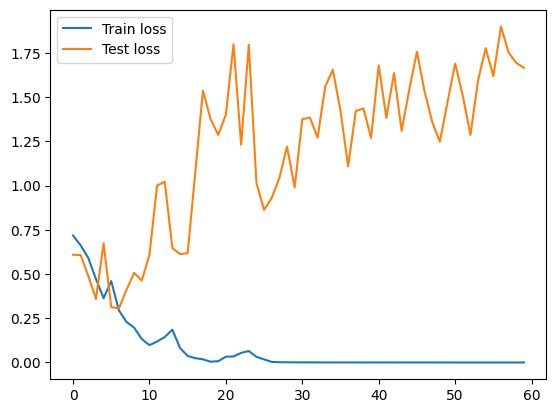

In [95]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()

plt.savefig("losses_plot.png")

In [74]:
X, y = next(iter(train_dataloader))
X[0]

tensor([26, 44, 29, 28, 23, 19,  2, 33, 30,  2, 20, 23, 26, 26, 19,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0], device='cuda:0')

In [144]:
seq = encode("éléonore,boulangère,fille,25")
seq = seq + [0] * (block_size - len(seq))
seq = torch.tensor([seq], device=device, dtype=torch.long)
seq

tensor([[44, 26, 44, 29, 28, 29, 32, 19,  2, 16, 29, 35, 26, 15, 28, 21, 43, 32,
         19,  2, 20, 23, 26, 26, 19,  2,  7, 10,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]], device='cuda:0')

In [145]:
nn.Sigmoid()(model(seq))

tensor([[0.3570]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [104]:
from torcheval.metrics import BinaryF1Score, BinaryAccuracy

def get_f1_score(model, dataloader):
    model.eval()

    f1_score = BinaryF1Score()
    accuracy = BinaryAccuracy()

    with torch.no_grad():
        for data, target in dataloader:
            logits = model(data)
            probs = nn.Sigmoid()(logits.squeeze())
            pred = (probs > 0.5).int()
            f1_score.update(pred, target)
            accuracy.update(pred, target)

    return {
        "f1_score": f1_score.compute().item(),
        "accuracy": accuracy.compute().item(),
    }

In [107]:
get_f1_score(model, test_dataloader)

{'f1_score': 0.875, 'accuracy': 0.9200000166893005}

## Combining the two?

In [ ]:
class MelangeModel(nn.Module):
    def __init__(self, simple_model, n_classes):
        super().__init__()
        self.


    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        for block in self.attention_blocks:
            x = block(x) # (B, T, C)

        x = x.mean(dim=1) # (B, C)

        logits = self.classifier(x) # (B, n_classes)

        return logits
        